In [1]:
from itertools import combinations, chain
import numpy as np
from z3 import *
import utils
import SAT_constraints
import logging

In [2]:
# Define your preferred logging level
logging.basicConfig(format='[%(levelname)s] %(message)s', level=logging.INFO)

In [3]:
WIDTH = 0
HEIGHT = 1

In [4]:
# Ensures that the circuits are connected
def coherent_cicuits(bool_vars, dims, n, w, upper_bound):
    constraints = []
    for c in range(1, n + 1):
        c_constraints = []
        height = dims[c - 1][HEIGHT]
        width = dims[c - 1][WIDTH]
        if upper_bound < height: 
            logging.info(f"l ({upper_bound}) is less than hight ({height}) of block {c}, so the block {c} must be rotated.")
            # Block is to high for the lower bound. Have to check if it can be rotated.
            if ((upper_bound >= width) and (height <= w)): 
                # Block fits if it is rotated. have to add only rotated posiiton to constraints.
                rotated = [And([bool_vars[x+j][y+i][c] for i in range(width) for j in range(height)]) for x in range(w - (height - 1)) for y in range(upper_bound - (width - 1)) ] 
                ex = SAT_constraints.exactly_one_seq(rotated, f"coherent_{c}")
                constraints.append(ex)
            else: 
                logging.info(f"l ({upper_bound}) is less than hight ({height}) of block {c}, and it's height ({height}) is greater than w ({w}). Block {c} it can not be rotated, and l must increase ")
        else:
            for x in range(w - (width - 1)):
                for y in range(upper_bound - (height - 1)):
                    normal = []
                    rotated = []
                    # Should it be strictly less than or less than and equal here?
                    rotation_possible = ((x+height) < w) and ((y+width) < upper_bound) and (width != height)
                    for i in range(width):
                        for j in range(height):
                            normal.append(bool_vars[x+i][y+j][c])
                            if rotation_possible: 
                                rotated.append(bool_vars[x+j][y+i][c])
                    
                    c_constraints.append(And(normal))
                    if len(rotated)>0:
                        c_constraints.append(And(rotated))
            # constraints.append(Or(c_constraints))  
            ex = SAT_constraints.exactly_one_seq(c_constraints, f"coherent_{c}")
            constraints.append(ex)
              
    return And(constraints)



In [5]:
def create_contraints(w, n, dims, upper_bound):
    s = Solver()

    # Model the problem
    v = [[[Bool(f"v_{x}_{y}_{c}") for c in range(0, n + 1)] for y in range(upper_bound)] for x in range(w)]
    
    # At most one circuit in each grid cell
    for x in range(w):
        for y in range(upper_bound):
            predicate = v[x][y]
            s.add(SAT_constraints.at_most_one_seq(predicate, f"valid_cell_{x}_{y}"))    
    
    # Ensure the right amount of empty cells -> Ensures that each circuit don't expand more than their dimension
    total_white_cells = (upper_bound * w) - sum(dims[:, WIDTH] * dims[:, HEIGHT])
    if total_white_cells > 0:
        predicate = [v[x][y][0] for x in range(w) for y in range(upper_bound)]
        s.add(SAT_constraints.exactly_k_seq(predicate, total_white_cells, f"white_cells_{x}_{y}_{0}"))
    
    s.add(coherent_cicuits(v, dims, n, w, upper_bound))
    
    return s, v

In [6]:
def compute_lb(w, dims):
    n_rows = math.ceil(sum(dims[:, WIDTH]) / w)
    sorted_heights = sorted(dims[:, HEIGHT])
    lb = np.sum(sorted_heights[:n_rows])
    #l = lb if lb >= max(dims[:, HEIGHT]) else max(dims[:, HEIGHT])
    l = lb
    return l

In [7]:
def compute_solution(model: ModelRef, v, w, n, l):
    sol = []

    for x in range(w):
        sol.append([])
        for y in range(l):
            found_circuit = False
            for c in range(1, n + 1):
                if model.evaluate(v[x][y][c]):
                    found_circuit = True
                    sol[x].append(c)
            if not found_circuit:
                sol[x].append(0)
    return sol

In [26]:
def all_smt(s, initial_terms):
    # https://stackoverflow.com/questions/11867611/z3py-checking-all-solutions-for-equation/70656700#70656700
    logging.info(f"Looking for all solutions for l= {l}") 
    def block_term(s, m, t):
        s.add(t != m.eval(t, model_completion=True))
    def fix_term(s, m, t):
        s.add(t == m.eval(t, model_completion=True))
    def all_smt_rec(terms):    
        if sat == s.check():
           logging.info(f"Have found another solution(s) for l= {l}") 
           m = s.model()
           yield m
           for i in range(len(terms)):
               s.push()
               block_term(s, m, terms[i])
               for j in range(i):
                   fix_term(s, m, terms[j])

               # Calls it self recursively till the solution is no longer sat 
               yield from all_smt_rec(terms[i:])
               s.pop()   
    yield from all_smt_rec(list(initial_terms))

In [27]:
def vlsi_design_one_solution(instance_number: int, visualize = True) -> None:
    file_path = f"../instances/ins-{instance_number}.txt"
    w, n, dims = utils.read_output(file_path)
    l = compute_lb(w, dims)
    logging.info(f"Trying with l= {l}")
    s, v = create_contraints(w, n, dims, l)

    while(not s.check()==sat):
        l += 1
        logging.info(f"Trying again with l= {l}")
        s, v = create_contraints(w, n, dims, l)

    model = s.model()
    sol = compute_solution(model, v, w, n, l)
    if visualize:
        utils.visualize_w_color_rotation(sol, w, len(sol[0]), dims, title=f"Instance {instance_number}, l={l}")
    return w, n, l, dims, sol, s

In [28]:
def vlsi_design_all_solutions(instance_number: int, visualize = True) -> None:
    file_path = f"../instances/ins-{instance_number}.txt"
    w, n, dims = utils.read_output(file_path)
    l = compute_lb(w, dims)
    logging.info(f"Trying with l= {l}")
    s, v = create_contraints(w, n, dims, l)

    while(not s.check()==sat):
        l += 1
        logging.info(f"Trying again with l= {l}")
        s, v = create_contraints(w, n, dims, l)


    logging.info(f"Found one solution for l= {l}")
       
    flattened_v = np.array(v).flatten()
    
    solutionGenerator = all_smt(s, flattened_v)
    solutions = [compute_solution(model, v, w, n, l) for model in solutionGenerator]
    logging.info(f"Found {len(solutions)} solutions with length l = {l}")
    if visualize:
        for sol in solutions:
            utils.visualize_w_color_rotation(sol, w, len(sol[0]), dims, title=f"Instance {instance_number}, l={l}")
    return w, n, l, dims, solutions, solutionGenerator
    

In [29]:
def vlsi_design(instance_number: int, visualize = True, allSolutions=True) -> None:
    if allSolutions:
        return vlsi_design_all_solutions(instance_number, visualize)
    else:
        return vlsi_design_one_solution(instance_number, visualize)


### Run the SAT VLSI-Design

In [30]:
# Parse the solution to correct output form
def output_results(w, l, n, dims, sol, s):
    str = f"{w} {l}\n{n}\n"

    pos = {}
    for x in range(w):
      for y in range(l-1, 0, -1):
          c = sol[x][y]

          if c != 0 and c not in pos:
              pos[c] = [x, (l-1) - y]

              numb = sol[x].count(c)
              if numb != dims[c-1][1]:
                  pos[c].append("R")
          
    for i in range(n):
      rotated = 0
      if (len(pos.get(i + 1)) > 2):
        rotated = 1
      str += f"{dims[i][WIDTH + rotated]} {dims[i][HEIGHT - rotated]} {pos.get(i + 1)[0]} {pos.get(i + 1)[1]}\n"
    
    str += f"\n{s.statistics()}\n"
    return str

[INFO] Running file ./sat_solutions/sol_ins-1.txt
[INFO] Trying with l= 6
[INFO] Trying again with l= 7
[INFO] Trying again with l= 8
[INFO] Found one solution for l= 8
[INFO] Looking for all solutions for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Have found another solution(s) for l= 8
[INFO] Found 12 solutions with length l = 8


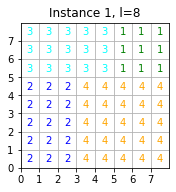

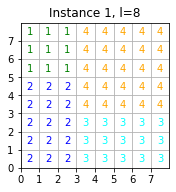

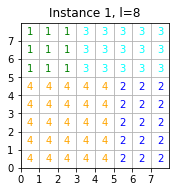

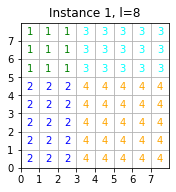

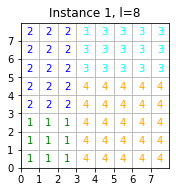

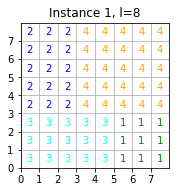

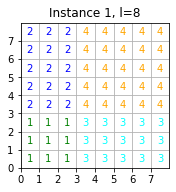

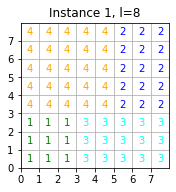

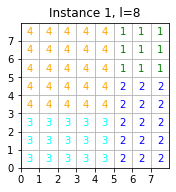

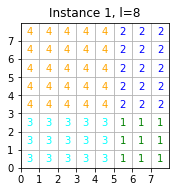

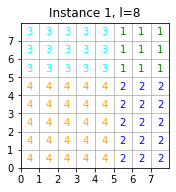

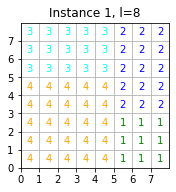

In [31]:
for i in range(1, 2):
    output_file = f"./sat_solutions/sol_ins-{i}.txt"
    logging.info(f"Running file {output_file}")
    w, n, l, dims, sol, s = vlsi_design(i)
    
    #output = output_results(w, l, n, dims, sol, s)
    #utils.write_output_to_file(output_file, output)